<a href="https://colab.research.google.com/github/dqj5182/weight-Initialization-method-using-monte-carlo-simulation/blob/main/ResNet_50_for_CIFAR_10_default_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms

In [15]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

In [16]:
data_transform = transforms.Compose([transforms.ToTensor(),
                                         transforms.RandomApply([transforms.RandomHorizontalFlip()]),
                                         transforms.RandomRotation(degrees=(-10, 10)),
                                         transforms.RandomAffine(degrees=0, translate=(.1, .1)),
                                         transforms.RandomApply([transforms.ColorJitter(brightness=(1, 1.2),
                                                                                        contrast=(1, 1.5),
                                                                                        saturation=(1, 1.5),
                                                                                        hue=(0, 0.5))]),
                                         transforms.RandomErasing(p=0.5, scale=(0.05, 0.05), ratio=(0.3, 3.3), value=0,
                                                                  inplace=False),
                                         transforms.Resize((75, 75)),
                                         transforms.Normalize((0.5,), (0.5,))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=data_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=data_transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


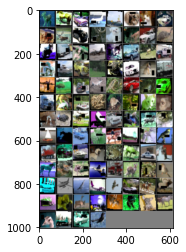

 deer horse   car plane  ship   cat   cat   dog horse  deer   car  deer   dog  deer   car  bird   dog truck   dog plane   cat   car horse truck truck  ship truck  deer  frog   car   dog truck plane  bird   car  deer  frog   car  frog   car truck  frog  ship  frog  bird  deer   cat   dog   dog  bird  deer plane   car  bird horse   cat  ship   cat   car   cat horse  ship  bird  bird truck   car  ship   dog  frog  deer   car   cat horse  deer  bird plane truck  deer  frog  bird   car plane plane plane  bird  ship horse  deer  ship   cat  deer plane   cat  frog   dog horse  bird truck   car  bird


In [17]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [18]:
import torch.nn as nn
import torch.nn.functional as F


resnet50 = models.resnet50(pretrained=True)

n_inputs = resnet50.fc.in_features

last_layer = nn.Sequential(
                nn.Linear(n_inputs, len(classes)))

resnet50.fc = last_layer

if train_on_gpu:
    resnet50.cuda()

In [19]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.001)

# Exponential Decay to strengthen learning
decayRate = 0.999
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

In [20]:
def train_model(train_loader, optimizer, resnet50, criterion, my_lr_scheduler, n_epochs):
    # track training loss over time
    losses = []
    
    for epoch in range(1, n_epochs + 1):

        # keep track of training and validation loss
        train_loss = 0.0

        # model by default is set to train
        for batch_i, (data, target) in enumerate(train_loader):
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = resnet50(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()

            my_lr_scheduler.step()

            if batch_i % 100 == 99:  # print training loss every specified number of mini-batches
                print('Epoch %d, Batch %d loss: %.16f' %
                    (epoch, batch_i + 1, train_loss / 100))
                losses.append(train_loss / 100)
                train_loss = 0.0

    return resnet50, losses

In [21]:
n_epochs = 10

resnet50, train_losses = train_model(train_loader, optimizer, resnet50, criterion, my_lr_scheduler, n_epochs)

Epoch 1, Batch 100 loss: 1.3702617770433425
Epoch 1, Batch 200 loss: 0.9375509458780289
Epoch 1, Batch 300 loss: 0.7856217765808106
Epoch 1, Batch 400 loss: 0.7298140454292298
Epoch 1, Batch 500 loss: 0.6641509088873864
Epoch 2, Batch 100 loss: 0.5953975895047188
Epoch 2, Batch 200 loss: 0.5523242321610451
Epoch 2, Batch 300 loss: 0.5373298513889313
Epoch 2, Batch 400 loss: 0.5000710302591324
Epoch 2, Batch 500 loss: 0.4624702998995781
Epoch 3, Batch 100 loss: 0.4077850839495659
Epoch 3, Batch 200 loss: 0.4095116999745369
Epoch 3, Batch 300 loss: 0.3970522890985012
Epoch 3, Batch 400 loss: 0.3696086533367634
Epoch 3, Batch 500 loss: 0.3689284367859363
Epoch 4, Batch 100 loss: 0.3283126790821552
Epoch 4, Batch 200 loss: 0.3272913148999214
Epoch 4, Batch 300 loss: 0.3023282408714295
Epoch 4, Batch 400 loss: 0.2985177458822727
Epoch 4, Batch 500 loss: 0.2749512958526611
Epoch 5, Batch 100 loss: 0.2563812352716923
Epoch 5, Batch 200 loss: 0.2503519311547279
Epoch 5, Batch 300 loss: 0.25063

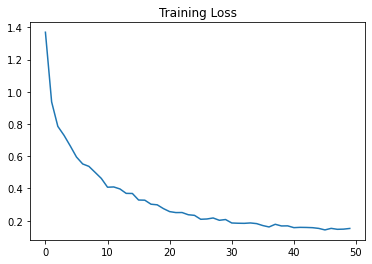

In [22]:
plt.plot(train_losses)
plt.title("Training Loss")
plt.show()

In [23]:
def test_model(classes, resnet50, test_loader, criterion):
    # track test loss
    test_loss = 0.0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))

    resnet50.eval()  # eval mode

    labels = []
    predictions = []
    # iterate over test data
    for data, target in test_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = resnet50(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update  test loss
        test_loss += loss.item() * data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(len(target.data)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
        
        # Will be used for calculating Recall, Precision, and F1-score
        labels.extend(target.data.view_as(pred).tolist())
        predictions.extend(pred.tolist())


    # calculate avg test loss
    test_loss = test_loss / len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    return test_loss, class_correct, class_total, labels, predictions

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [25]:
# The test_model function is from model_testing python file
test_loss, class_correct, class_total, labels, predictions = test_model(classes, resnet50, test_loader, criterion)

# Test accuracy for each hieroglyph
for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (classes[i], 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

# Total Test accuracy
print("\nAccuracy: {:.3%}".format(accuracy_score(labels, predictions)))
print("\nPrecision: {:.3%}".format(precision_score(labels, predictions, average = 'weighted')))
print("\nRecall: {:.3%}".format(recall_score(labels, predictions, average = 'weighted')))
print("\nF1-score: {:.3%}".format(f1_score(labels, predictions, average = 'weighted')))

Test Loss: 0.273428

Test Accuracy of plane: 91% (919/1000)
Test Accuracy of   car: 95% (953/1000)
Test Accuracy of  bird: 89% (895/1000)
Test Accuracy of   cat: 83% (831/1000)
Test Accuracy of  deer: 90% (905/1000)
Test Accuracy of   dog: 84% (844/1000)
Test Accuracy of  frog: 93% (936/1000)
Test Accuracy of horse: 94% (941/1000)
Test Accuracy of  ship: 95% (952/1000)
Test Accuracy of truck: 93% (933/1000)

Accuracy: 91.090%

Precision: 91.090%

Recall: 91.090%

F1-score: 91.086%
